# Creating figures for data from more than one group

## Required data 

Each participant should have a separate folder where their spectra and MRS voxels should be stored. The folders should be arranged as follows:

```
project_folder
|   participants.tsv
|
└───data_folder
    |    
    └───sub-01
    |   |    spectrum.tsv
    |   |    spectrum_frequencies.tsv
    |   |    mrs-voxel_mni-space.nii.gz
    |   |    ...
    |
    └───sub-02
    |   |    spectrum.tsv
    |   |    spectrum_frequencies.tsv
    |   |    mrs-voxel_mni-space.nii.gz
    |   |    ...
    |
    |...
```

Participant IDs should be contained in the participants.tsv file. They should be in a column entitled "participant_id". 

This file should also specify which group each participant belongs to in a column entitled "group". In this example we use two groups called "group1" and "group2". More than two groups can be processed with some minor changes to the code.

Spectrum files should contain a single column with the preprocessed MRS spectra that you wish to display. The related frequencies file should contain a single column with the corresponding frequencies in PPM. 

In this example we use a MEGA-PRESS difference spectra created with the Gannet toolbox (http://www.gabamrs.com/). In the case of Gannet, these files must be written out from the data file created during the analysis. This step will differ depending on the analysis tools that you are using. 

MRS voxels should be in compressed NIFTI format. These should have been aligned to the MNI152 standard space with a 2mm resolution. 


## Make a voxel overlap image

First define the directories and files to be used and load in the participant IDs.

In [2]:
import os
import numpy as np
import pandas as pd

# Project directory
data_dir = '/home/niall/work/MRS-voxel-plot/how-to/'

# Directory to create figures in
fig_dir = os.path.join(data_dir,'figures')

# Check if this figure directory exists, and if not create it
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    
# Define the columns in which participant ID and group membership are stored in the tsv file
ID_header = 'participant_id'
group_header = 'group'

# Naming of the group categories:
group_name_1='group1'
group_name_2='group2'

# Load in the participant IDs and group information
subjects =  pd.read_csv(data_dir+'participants.tsv', delimiter='\t')[ID_header]
groups =  pd.read_csv(data_dir+'participants.tsv', delimiter='\t')[group_header]
n_subs_1 = sum(isinstance(name, str) for name in groups if name==group_name_1)
n_subs_2 = sum(isinstance(name, str) for name in groups if name==group_name_2)

# Define the voxel mask filename
mask_name = 'mrs-voxel_mni-space.nii.gz'

To create the overlap image we first need to establish the image dimensions and the affine matrix that defines its orientation. 

In [3]:
import nibabel as ni

# Use the first subject as an examplar for the dimensions and matrix
def get_mask_info(fpath):
    tmp = ni.load(fpath)
    aff = tmp.affine
    dims = tmp.shape
    return(aff,dims)

mask_file = os.path.join(data_dir,'example-data',subjects[0],mask_name)
mask_aff, mask_dims = get_mask_info(mask_file)

We now load the masks for the participants into two arrays and calculate the percent overlap for each.

In [6]:
# Load data
mask_data_group_1 = np.zeros(np.hstack((n_subs_1,mask_dims)))
mask_data_group_2 = np.zeros(np.hstack((n_subs_2,mask_dims)))

idx1=0
idx2=0
for i,sub in enumerate(subjects):
    mask_file = os.path.join(data_dir,'example-data',sub,mask_name)
    if groups[i] == group_name_1:
        mask_data_group_1[idx1,:,:,:] = ni.load(mask_file).get_fdata()
        idx1 = idx1+1
    if groups[i] == group_name_2:
        mask_data_group_2[idx2,:,:,:] = ni.load(mask_file).get_fdata()
        idx2 = idx2+1

# Calculate the overlap between voxels
density_1 = np.sum(mask_data_group_1, axis = 0)
density_1 = (density_1/n_subs_1)*100
density_2 = np.sum(mask_data_group_2, axis = 0)
density_2 = (density_2/n_subs_2)*100

# Create NIFTI images for density maps
density_map_1 = ni.Nifti1Image(density_1,mask_aff)
density_map_2 = ni.Nifti1Image(density_2,mask_aff)

The overlap images can now be plotted on the glass brain provided in nilearn (https://nilearn.github.io). 

Plotting is done with matplotlib. This uses inches to define the image dimensions and so we define a helper function so we can input dimensions in cm. 

Here we use the *Reds* and *Blues* colourmaps for the plotting the two groups, but any matplotlib compatible colourmaps can be used (see https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html)


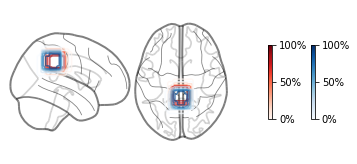

In [10]:
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import ticker
import matplotlib.gridspec as gridspec

# cm to inch convertor
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

# Define the filename for the image
fig_file = os.path.join(fig_dir,'voxel-density-map_multiple-groups.png')
    
# Plot the figure
fig = plt.figure()
fig.set_size_inches(cm2inch(14,7)) # width, height

gs = gridspec.GridSpec(1, 3,width_ratios=[9,1,1])
ax1 = plt.subplot(gs[0])

display=plotting.plot_glass_brain(None, threshold=0, colorbar=False, axes=ax1, 
                                  display_mode='xz',alpha=0.5,annotate=False)
display.add_contours(density_map_1, cmap='Reds',alpha=0.7)
display.add_contours(density_map_2, cmap='Blues',alpha=0.7)

ax2 = plt.subplot(gs[1]) # Add two separate colourbars
a = np.array([[0,1]])
img = plt.imshow(a, cmap="Reds",axes=ax2)
ax2.set_visible(False)
plt.colorbar(ax=ax2)

ax3 = plt.subplot(gs[2])
a = np.array([[0,1]])
img = plt.imshow(a, cmap="Blues",axes=ax3)
ax3.set_visible(False)
plt.colorbar(ax=ax3)

for ax in plt.gcf().axes: # Adjust the colourbar to percentages
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Save the figure
fig.savefig(fig_file,bbox_inches='tight',dpi=300)


It can also be useful to have the nifti file of these overlap maps to use in other ways so, finally, we create those.

In [11]:
# Save density map NIFTI file
density_map_1.to_filename(fig_dir+'voxel_density_map_group_1.nii.gz')
density_map_2.to_filename(fig_dir+'voxel_density_map_group_2.nii.gz')

## Make a voxel centroid image

We now make a figure showing the MRS voxel centroids for participants from each group.

Centroid coordinates are calculated using a helper function from nilearn. This requires separate images in a list structure so we need to reload all the masks.

In [7]:
# Load all masks into a list
all_masks = []
for i, sub in enumerate(subjects):
    mask_file = os.path.join(data_dir,'example-data',sub,mask_name)
    all_masks.append(ni.load(mask_file))
    
# Calculate centroids
all_centres = np.zeros((n_subs,3))
for i in range(n_subs):
    all_centres[i,:] = plotting.find_xyz_cut_coords(all_masks[i])

These centroids can be plotted onto the glass brain. 

Any colour definition that matplotlib can understand can be used. Here we use the basic "red" colour.

Plotting is done through the nilearn plot_connectome function. This expects an adjacency matrix for the points being plotted and so we create a blank one.

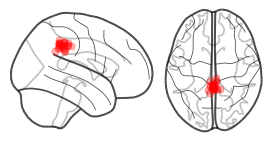

In [12]:
# Create a dummy adjacency matrix
adjacency_matrix = np.zeros((n_subs,n_subs))

# Define the filename for the image
fig_file = os.path.join(fig_dir,'mask-centroids_single-group.png')

# Set colour for points
node_colour = 'red'

# Plot the figure
fig = plt.figure()
fig.set_size_inches(cm2inch(12,6)) # width, height
ax1 = plt.subplot(111)
plotting.plot_connectome(adjacency_matrix=adjacency_matrix, node_coords=all_centres,
                         node_size=50, node_color=node_colour, display_mode='xz', 
                         node_kwargs={'alpha':0.3},axes=ax1,annotate=False)

# Save the figure
fig.savefig(fig_file,bbox_inches='tight',dpi=300)


## Make an image showing the spectrum

